## Bowling effectiveness by phase
### The curious case of the female pace bowler in the powerplay

To demonstrate the power of this database, even just for 2024 data, we will explore the effectiveness of different bowling styles in the different phases of T20 matches. We will be using a simple modification of the 'deliveries' table. The 'deliveries' table was merged with the 'players' table to attach bowling styles to each delivery, and then indicator columns for key phases of play were added. The csv files for this notebook are available in the notebooks/data/ directory.

We start by importing some basic data analysis and visualisation packages, setting some package options, and loading the csv file 'deliveries_for_analysis.csv'.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

df1 = pd.read_csv('data/deliveries_for_analysis.csv', low_memory=False)

/var/folders/4z/g3dh65y10x52gnzqpdwfq1qc0000gn/T/ipykernel_1674/4124838008.py:8: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('data/deliveries_for_analysis.csv')


We now consolidate the four binary phase columns into one categorical 'phase' column. We repeat a similar process for the bowling styles.

In [2]:
df1['phase'] = np.select(
    [df1['powerplay'] == 1, df1['middle_overs'] == 1, df1['death_overs'] == 1],
    ['Powerplay', 'Middle Overs', 'Death Overs'],
    default='Super Over'
)

df1['style_class'] = df1['bowl_style'].apply(lambda x: 'Pace' if 'Seam' in str(x) else ('Spin' if 'break' in str(x) or 'Ortho' in str(x) or 'Unortho' else 'Other'))
# There is one bowler who bowled in 2024, Suryakumar Yadav, that bowls both pace and spin. His deliveries were edited manually to correct the bowling style for them.

Next, we aggregate the data by these two columns and then calculate bowling strike rate (balls per wicket) for each of the phases. We also print the aggregated data we will plot just to get some idea of the raw numbers.

In [3]:
bowler_wickets = ['bowled', 'caught', 'caught and bowled', 'lbw', 'stumped', 'hit wicket']
df1['bowler_wicket'] = df1['how_out'].isin(bowler_wickets).astype(int)

phase_agg = df1.groupby(['phase', 'style_class', 'sex']).agg(
    total_balls=('phase', 'size'), # We include deliveries where no balls or wides were bowled - these are the bowler's responsibility
    bowler_wickets=('bowler_wicket', 'sum')
).reset_index()

phase_agg['bowling_strike_rate'] = phase_agg.apply(
    lambda row: row['total_balls'] / row['bowler_wickets'] if row['bowler_wickets'] > 0 else np.nan,
    axis=1
)

We now produce a graph considering the bowling strike rate by bowling style and game phase.

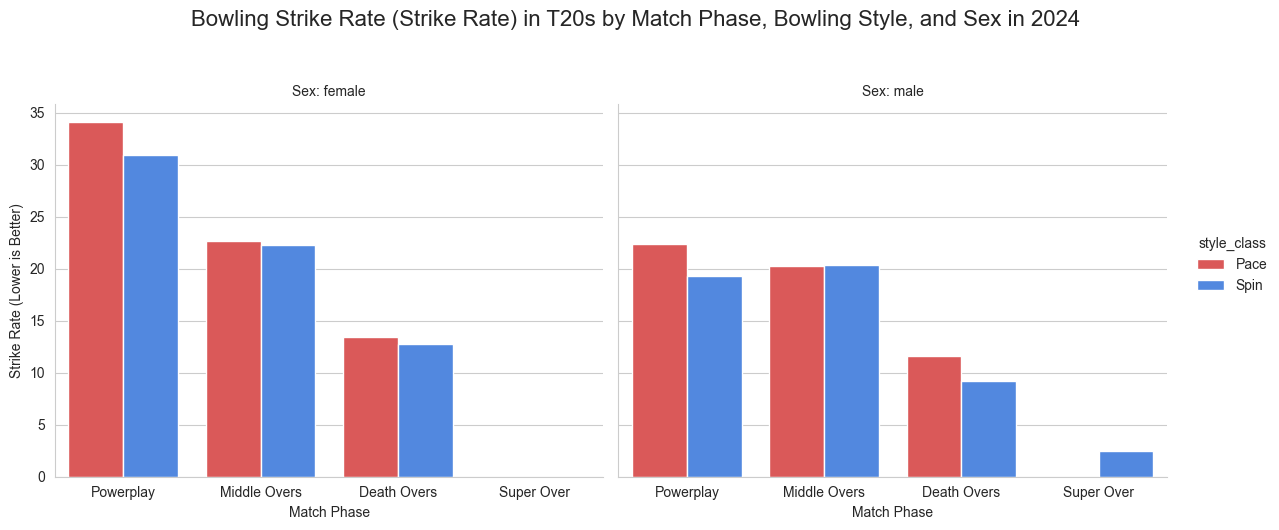

In [4]:
g1 = sns.catplot(
    data=phase_agg.dropna(subset=['bowling_strike_rate']),
    x='phase',
    y='bowling_strike_rate',
    hue='style_class',
    col='sex',
    kind='bar',
    order=['Powerplay', 'Middle Overs', 'Death Overs', 'Super Over'],
    hue_order=['Pace', 'Spin'],
    palette={'Pace': '#ef4444', 'Spin': '#3b82f6'},
    errorbar=None,
    height=5,
    aspect=1.2
)

g1.fig.suptitle('Bowling Strike Rate (Strike Rate) in T20s by Match Phase, Bowling Style, and Sex in 2024', fontsize=16, y=1.05)
g1.set_titles("Sex: {col_name}")
g1.set(xlabel="Match Phase", ylabel="Strike Rate (Lower is Better)")
g1.tight_layout()
plt.show()

As expected, this graph shows that wickets are significantly more frequent in the death overs (overs 17–20 in a T20 game) in both men's and women's cricket. This is likely due to the increased risk that batters take as the balls remaining dwindle. After all, unused wickets at the end of a T20 innings are in some cases just wasted resources. The general trend in both graphs, with bowling strike rate decreasing (improving) through the innings for all bowling styles, also backs up this point. An exception to this is spin in the men's game, where bowling strike rate increases slightly from the powerplay to the middle overs. This is likely because spin is usually only deployed in the powerplay when the spinner has a favourable match up with a batter, or if the spinner is particularly skilful (which would imply that they take more frequent wickets anyway). Spin was particularly effective in general in 2024 for frequent wicket-taking, likely as the ICC Men's and Women's T20 World Cups were played on spin-friendly pitches in the Caribbean and the UAE respectively.

The data clearly delineates the middle overs (strike rate ≈20−22 balls/wicket) as a lower-risk phase from the death overs (≈9−14 b/w), highlighting how batters may transition from accumulation to high-risk attack. This could be better investigated by looking at batting strike rates and also making specific comparisons between the couple of overs surrounding that transition from middle to death overs.

Interestingly, powerplay bowling strike rate is significantly higher in women's internationals, particularly for women's pace bowlers. The differences in the other phases could be a matter of the sample, but I found the size of the gap in the powerplay to be unexpected: for female cricket, pace bowling in the powerplay has a strike rate of roughly 34 balls per wicket, compared to 22 in male cricket. I anticipated that batters would be incentivised to take the same relative (high) risk in the powerplay as in the men’s game, leading to at least as frequent wickets. Perhaps the batters are able to score quickly without taking on as much risk as in the men’s game, or maybe there is something else at play. Moreover, my visual perception of women's pace bowling is that they 'swing' the ball more than their male counterparts. I expected this to make pace bowling in this phase as least as effective for wicket-taking as in the middle overs. Given the low efficiency, we can question: are these deliveries restricting runs (economy rate), or are batters simply surviving the movement?  There are several reasons for these unexpected results, including greater relative skill discrepancies between women's teams in the sample, general wicket-taking strategies, and the relatively small sample. It certainly warrants further investigation.

To investigate whether it could be due to greater relative skill discrepancies, we will remove matches involving Ireland or Zimbabwe from the women's data. Neither side qualified for the ICC Women's T20 World Cup 2024, which makes up around 20% of the women's games in this dataset, and were ranked 10th and 14th by the ICC in December 2024. As is the case in many sports, cricket's poor investment in the women's game - outside the biggest nations - means that both Ireland and Zimbabwe only handed out their first full-time professional contracts in 2022. For comparison, Cricket Ireland handed out the first full-time mens contracts in 2009, 8 years before they became a full-member nation.

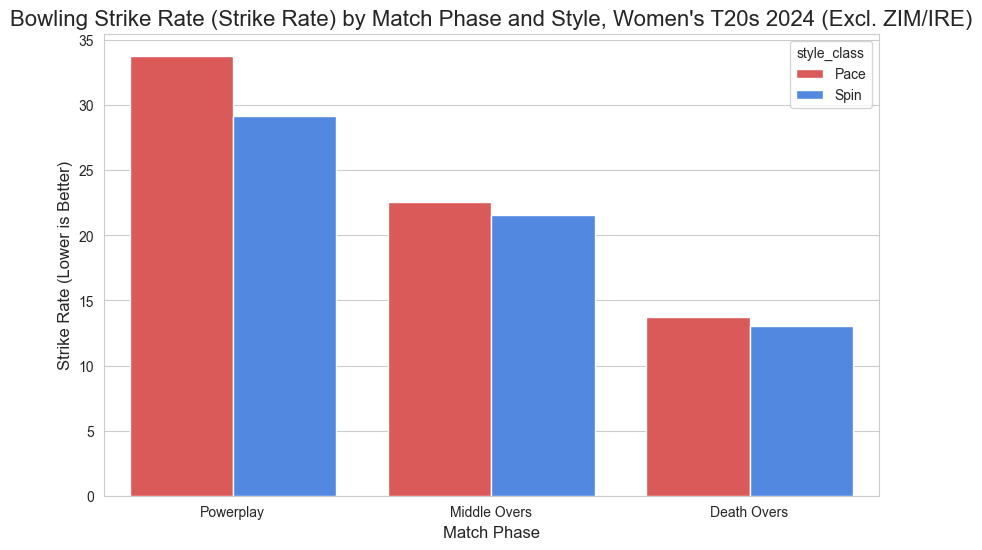

In [5]:
games_to_drop = [1415983, 1430813, 1458415, 1415985, 1458414, 1415984, 1430812, 1425647, 1415987, 1415986, 1458416, 1430821, 1430820]
filtered_df1 = df1[(~df1['match_id'].isin(games_to_drop)) & (df1['sex'] == 'female')]

filtered_phase_agg = filtered_df1.groupby(['phase', 'style_class']).agg(
    total_balls=('phase', 'size'),
    bowler_wickets=('bowler_wicket', 'sum')
).reset_index()

filtered_phase_agg['bowling_strike_rate'] = filtered_phase_agg.apply(
    lambda row: row['total_balls'] / row['bowler_wickets'] if row['bowler_wickets'] > 0 else np.nan,
    axis=1
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=filtered_phase_agg.dropna(subset=['bowling_strike_rate']),
    x='phase',
    y='bowling_strike_rate',
    hue='style_class',
    order=['Powerplay', 'Middle Overs', 'Death Overs'],
    hue_order=['Pace', 'Spin'],
    palette={'Pace': '#ef4444', 'Spin': '#3b82f6'},
    zorder=3
)

plt.title(f"Bowling Strike Rate (Strike Rate) by Match Phase and Style, Women's T20s 2024 (Excl. ZIM/IRE)", fontsize=16)
plt.xlabel("Match Phase", fontsize=12)
plt.ylabel("Strike Rate (Lower is Better)", fontsize=12)
plt.grid(axis='y', zorder=0)
plt.show()

This graph shows a slight reduction in bowling strike rate in the powerplay for spin (an increase in bowling potency), but no reduction for pace bowling, which is still much higher than in the men's game. This suggests that the main factor in this difference is not greater relative skill discrepancies between women's teams.  As such, we will return Zimbabwe and Ireland to the dataset due to its already small sample size of 90 women's games.

We will next consider whether the low bowling strike rate for female pace bowlers in the powerplay is making them ineffective. If they are conceding few runs and hence building pressure on the batters, it can be posited that they are still effective in inducing greater risk-taking in the middle overs, and more wickets in this phase. To do this, we calculate the bowler economy rates, and the batting strike rates for each of these phases and bowling types.

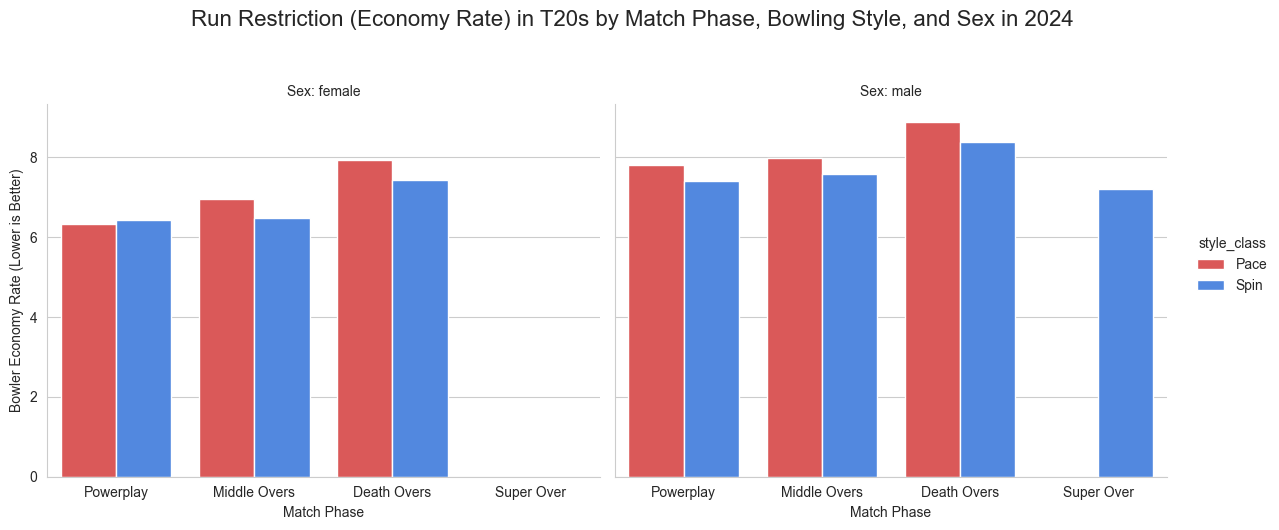

In [6]:
econ_df1 = df1.copy()
econ_df1.loc[:, 'bowler_runs'] = econ_df1.loc[:, 'runs_batter'] + econ_df1.loc[:, 'extras_wides'] + econ_df1.loc[:, 'extras_noballs']
econ_df1.loc[:, 'ball_faced'] = econ_df1.apply(lambda row: 1 if row['extras_wides'] == 0 else 0, axis=1)

econ_phase_agg = econ_df1.groupby(['phase', 'style_class', 'sex']).agg(
    total_balls=('phase', 'size'),
    batter_balls=('ball_faced', 'sum'),
    bowler_wickets=('bowler_wicket', 'sum'),
    batter_runs=('runs_batter', 'sum'),
    bowler_runs=('bowler_runs', 'sum'),
    total_runs=('runs_total', 'sum')
).reset_index()

econ_phase_agg['bowling_strike_rate'] = econ_phase_agg.apply(
    lambda row: row['total_balls'] / row['bowler_wickets'] if row['bowler_wickets'] > 0 else np.nan,
    axis=1
)

econ_phase_agg['bowling_strike_rate'] = econ_phase_agg.apply(
    lambda row: row['total_balls'] / row['bowler_wickets'] if row['bowler_wickets'] > 0 else np.nan,
    axis=1
)

econ_phase_agg['bowler_economy_rate'] = econ_phase_agg.apply(
    lambda row: (row['bowler_runs'] / row['total_balls']) * 6 if row['total_balls'] > 0 else np.nan,
    axis=1
)

g2 = sns.catplot(
    data=econ_phase_agg.dropna(subset=['bowler_economy_rate']),
    x='phase',
    y='bowler_economy_rate',
    hue='style_class',
    col='sex',
    kind='bar',
    order=['Powerplay', 'Middle Overs', 'Death Overs', 'Super Over'],
    hue_order=['Pace', 'Spin'],
    palette={'Pace': '#ef4444', 'Spin': '#3b82f6'},
    errorbar=None,
    height=5,
    aspect=1.2
)

g2.fig.suptitle('Run Restriction (Economy Rate) in T20s by Match Phase, Bowling Style, and Sex in 2024 ', fontsize=16, y=1.05)
g2.set_titles("Sex: {col_name}")
g2.set(xlabel="Match Phase", ylabel="Bowler Economy Rate (Lower is Better)")
g2.tight_layout()
plt.show()

Plotting bowler economy rate (excludes run conceded through byes, leg byes, and penalties) shows that across each phase, economy rates are higher in the men's game, but the trend is the same: bowlers concede more runs per over in each successive phase. As the two games are at different levels of strategic and skill development, it is futile to draw conclusions about the relative skill levels of players, e.g. whether batters are better in the men's game, or female bowlers are better etc. However, much like in the comparison of bowling strike rates, female pace bowlers stand out amongst our limited trend. In general, spin is more economical than pace in each phase, but female pace bowlers in the powerplay are the most economical style-phase pairing overall, conceding slightly more than six runs per over on average.

To check the stability of this finding, especially the distinct powerplay trends, we can consult an older, less detailed version of the database with a larger sample size. Whilst we cannot split the data by bowling style in this older set, the much higher overall powerplay bowling strike rate persists. This illustrates that the high female powerplay bowling strike rates are at least in line with the general trend. Hence, we can put some faith in this being a persistent trend worth investigating.

What makes this persistent powerplay trend so important? Conventional wisdom suggests that powerplay wickets are crucial to success in T20s. The previously generated phase_agg table showed that in our sample of women's cricket, pace bowlers deliver about 62% of balls bowled in this phase. But given their relatively poor powerplay strike rates, if powerplay wickets are well-correlated with success in women's cricket, having a particularly potent pace-bowling powerplay wicket taker would be a sizeable competitive advantage. To study the importance of powerplay wickets for winning in women's cricket, we will require our next table powerplay_summaries.csv, and we start with some aggregation.

In [8]:
df2 = pd.read_csv('data/powerplay_summaries.csv')

num_wickets_pp = df2.groupby(['total_wickets_lost', 'sex']).agg(
    instances=('total_wickets_lost', 'count'),
    wins=('winner', 'sum')
)

num_wickets_pp['win_prop'] = num_wickets_pp.apply(
    lambda row: row['wins'] / row['instances'] if row['instances'] > 0 else np.nan,
    axis=1
)

num_wickets_pp['win_pct'] = num_wickets_pp.apply(
    lambda row: round(row['win_prop'] * 100, 2) if row['instances'] is not np.nan else np.nan,
    axis=1
)

bins = [0, 30, 45, 60, 100]  # Bins selected from a quick look at a histogram of the data
labels = ['< 30 Runs', '30-44 Runs', '45-59 Runs', '60+ Runs']

df2['pp_runs_category'] = pd.cut(
    df2['pp_runs'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

run_win_analysis = df2.groupby(['pp_runs_category', 'sex'], observed=True).agg(
    instances=('pp_runs_category', 'size'),
    wins=('winner', 'sum')
).reset_index()

run_win_analysis['win_pct'] = (run_win_analysis['wins'] / run_win_analysis['instances']) * 100

/var/folders/4z/g3dh65y10x52gnzqpdwfq1qc0000gn/T/ipykernel_1674/317032078.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  run_win_analysis = df2.groupby(['pp_runs_category', 'sex']).agg(


We now will produce a plot to consider how runs scored and wickets lost in the powerplay impact the batting team's winning percentage.

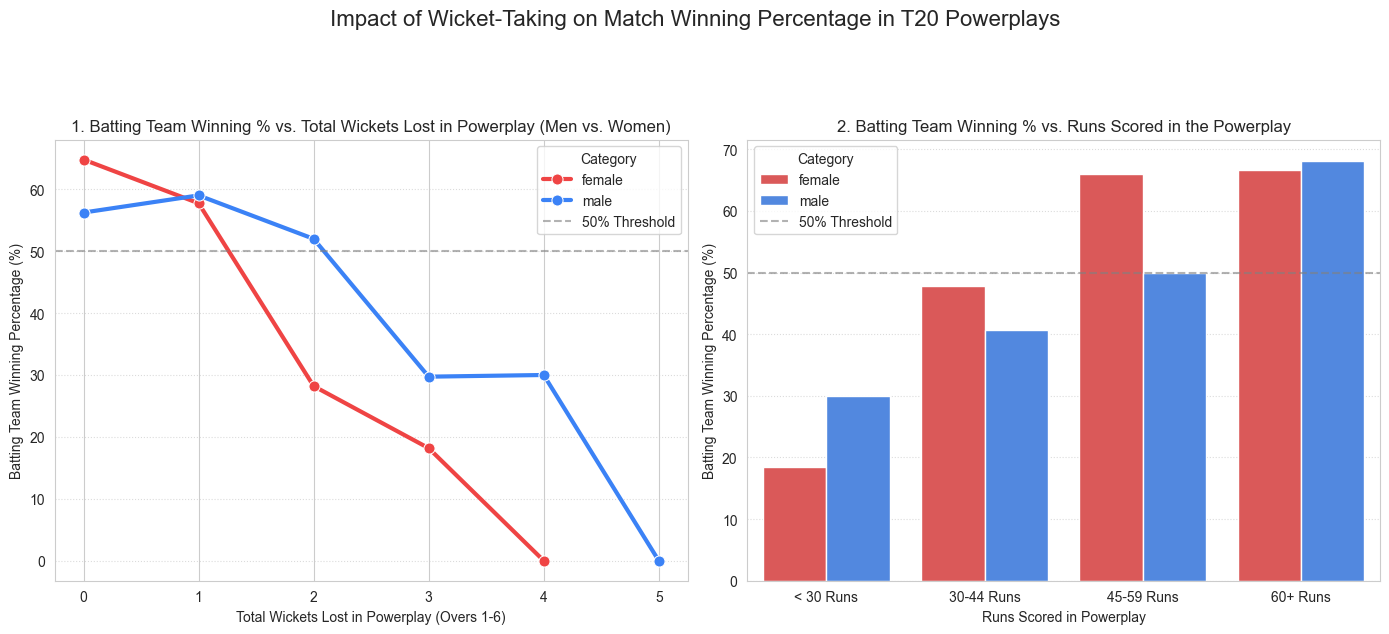

In [9]:
num_wickets_pp = num_wickets_pp.reset_index()

num_wickets_pp['total_wickets_lost'] = pd.to_numeric(num_wickets_pp['total_wickets_lost'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Impact of Wicket-Taking on Match Winning Percentage in T20 Powerplays', fontsize=16, y=1.05)

sns.lineplot(
    data=num_wickets_pp,
    x='total_wickets_lost',
    y='win_pct',
    hue='sex',
    marker='o',
    markersize=8,
    linewidth=3,
    palette={'male': '#3b82f6', 'female': '#ef4444'},
    ax=axes[0]
)

axes[0].set_title('1. Batting Team Winning % vs. Total Wickets Lost in Powerplay (Men vs. Women)',
                  fontsize=12)
axes[0].set_xlabel('Total Wickets Lost in Powerplay (Overs 1-6)', fontsize=10)
axes[0].set_ylabel('Batting Team Winning Percentage (%)', fontsize=10)
axes[0].set_xticks(num_wickets_pp['total_wickets_lost'].unique())
axes[0].axhline(50, color='grey', linestyle='--', alpha=0.6, label='50% Threshold')
axes[0].legend(title='Category', loc='upper right')
axes[0].grid(axis='y', linestyle=':', alpha=0.7)

sns.barplot(
    data=run_win_analysis,
    x='pp_runs_category',
    y='win_pct',
    hue='sex',
    order=['< 30 Runs', '30-44 Runs', '45-59 Runs', '60+ Runs'],
    palette={'male': '#3b82f6', 'female': '#ef4444'},
    errorbar=None,
    ax=axes[1]
)

axes[1].set_title("2. Batting Team Winning % vs. Runs Scored in the Powerplay",
                  fontsize=12)
axes[1].set_xlabel('Runs Scored in Powerplay (Overs 1-6)', fontsize=10)
axes[1].set_ylabel('Batting Team Winning Percentage (%)', fontsize=10)
axes[1].axhline(50, color='grey', linestyle='--', alpha=0.6, label='50% Threshold')
axes[1].legend(title='Category', loc='upper left')
axes[1].grid(axis='y', linestyle=':', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The left-hand plot shows that teams in women’s T20s have a significantly higher winning percentage (65%) than in men’s teams (56%) when they don’t lose a wicket in the powerplay. For one wicket lost, the winning percentage for men's teams actually slightly increases (about 59%), suggesting minimal impact of losing this first wicket for risk-taking, or more likely, the result of a restricted sample size. In women's T20s, the winning percentage drops slightly to approximately 58%. The large divergence comes if a side loses two wickets in the powerplay. The batting teams’ winning percentage drops sharply in women’s cricket, down to approximately 28%. Men’s winning percentage, however, remains over 50%. For both categories, the winning percentage drops sharply below 50% when three wickets are lost. Beyond this point, specific conclusions are limited by a small sample size, but the general trend suggests the batting team's winning percentage continues its steep decline.

This may suggest that in women’s cricket teams there is a greater drop-off in batter’s effectiveness as you move through the batting order. We can hypothesise this leads to lower risk-taking in the powerplay, which, in turn, makes wicket-taking more difficult and contributes to the high pace bowling strike rate observed previously.

Intuitively, the right-hand graph shows that winning percentage increases with runs scored in the powerplay. Most interestingly, a highly economical powerplay (conceding less than 30 runs) is particularly effective in women’s cricket for maximising the bowling team’s win chance. While this data is at the extreme ends of the distribution and requires caution, it highlights a causal ambiguity: Are wickets falling because bowlers are bowling economically, or are batters struggling to score because frequent wickets (and new batters having to "get in") disrupt momentum? Mutual causation is likely but not guaranteed — a low-scoring powerplay can occur with zero wickets lost, illustrating the complexity.

Integrating these two findings with our prior analysis of pace bowling strike and economy rates suggests that women’s teams prioritise limiting powerplay runs (the second goal). The match data supports this: of 27 instances in 2024 where women's teams were constrained to under 30 runs, the batting team won only five. Conversely, large wicket hauls are rare (e.g. only five instances of four wickets). Given that losing just two wickets severely curtails the batting team’s win chance, teams clearly aim to prioritise frugality in their powerplay bowling. However, the data clearly shows that a potent, wicket-taking pace bowler represents a significant unexploited competitive advantage. Since such bowlers appear rare (indicated by the high average strike rate), teams would likely be willing to sacrifice some run economy for the higher wicket-taking return and the massive swing in winning percentage that comes with it.

In conclusion, the elevated pace bowling strike rate in women’s T20 powerplays is likely a reflection of teams prioritising run-rate containment through more defensive bowling methods. Further investigation using a larger sample or multivariate regression would be necessary to fully isolate and quantify the effects of these distinct powerplay strategies.